In [1]:
import numpy as np
import gym
import itertools
from gym import spaces
from gym.utils import seeding
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# current considerations:

# either my implementation
# => self.probabilistic_actions = list(range(2, n_actions  + 2))   # i would like separate actions
#   => action_q_values = q[state].copy()
#   => action_q_values[~legal_actions] = np.nan
#   => action = np.nanargmax(action_q_values)    # this breaks ties deterministically

# or the one that reproduces results from the book (but does not make much sense to me)
# this hill is only due to random tie breaking of the many probabilistic actions from B
# due to the many actions, it takes longer for the Q values to closely approximate their true values
# if (as in my implementation), nanargmax is just (equivilaent but deterministic tie breaking),
# then the q value is learned faster and therefore the curves of q learning and double q learning look 
# a lot more similar, except for the fact that dql converges faster of course

# => self.probabilistic_actions = list(range(n_actions))   # dont like it bc it includes LEFT and RIGHT
# => np.random.choice(np.where(b == b.max())[0])          # this breaks ties randomly

In [4]:
class ToyExampleEnv(gym.Env):
    """ Toy example environment to illustrate the problem of maximization bias """

    metadata = {'render.modes': []}
    
    LEFT = 0
    RIGHT = 1
    
    STATE_A = 0
    STATE_B = 1
    STATE_A_TERMINAL = 2
    STATE_B_TERMINAL = 3
    
    INITIAL_STATE = STATE_A
    TERMINAL_STATES = [STATE_A_TERMINAL, STATE_B_TERMINAL]

    def __init__(self,  mu=-0.1, std=1, n_actions=10):
        super().__init__()
        self.mu = mu
        self.std = std
        
        # self.probabilistic_actions = list(range(2, n_actions  + 2))
        self.probabilistic_actions = list(range(n_actions))
        
        # define actions
        self.actions = [self.LEFT, self.RIGHT] + self.probabilistic_actions
        self.nA = len(self.actions)
        self.action_space = spaces.Discrete(self.nA)
        
        # define states
        self.state = self.INITIAL_STATE
        self.states = [self.STATE_A, self.STATE_B, self.STATE_A_TERMINAL, self.STATE_B_TERMINAL]
        self.nS = len(self.states)
        
        # there are no observations
        self.observation_space = spaces.Tuple(())
        
        self.state_transitions = {
            self.STATE_A: {
                self.LEFT: self.STATE_B,
                self.RIGHT: self.STATE_A_TERMINAL,
            },
            self.STATE_B: {
                a: self.STATE_B_TERMINAL for a in self.probabilistic_actions
            },
            self.STATE_A_TERMINAL: {
                self.RIGHT: self.STATE_A_TERMINAL, # really does not matter which one
            },
            self.STATE_B_TERMINAL: {
                self.LEFT: self.STATE_B_TERMINAL, # really does not matter which one
            },
        }
        
        self.np_random = None
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return seed
        
    def step(self, action):
        assert self.action_space.contains(action)
        legal_transitions = self.state_transitions.get(self.state, dict())
        reward = 0
        if action in legal_transitions:
            if self.state == self.STATE_B:
                reward = self.np_random.normal(self.mu, self.std)
            self.state = legal_transitions[action]
            
        done = self.state in self.TERMINAL_STATES
        return self.state, reward, done, {}
    
    def legal_actions(self, state=None):
        legal_transitions = self.state_transitions.get(self.state, dict())
        mask = np.zeros(self.nA, dtype=bool)
        mask[list(legal_transitions.keys())] = True
        return mask
    
    def reset(self):
        self.state = self.INITIAL_STATE
        return self.state

In [5]:
class EpsilonGreedyPolicy(object):
    
    def __init__(self, *Q, epsilon=0.1, reduction="sum", tie_breaking="random"):
        self.Q = Q  # note that Q is an array of estimates
        self.epsilon = epsilon
        self.reduction = reduction
        self.np_random = None
        self.break_ties_randomly = tie_breaking == "random"
        self.seed()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return seed
    
    def sample_action(self, state, legal_actions, break_ties_randomly=True):
        if self.reduction == "sum":
            q = np.array(self.Q).sum(axis=0)
        elif self.reduction == "mean":
            q = np.array(self.Q).mean(axis=0)
        else:
            raise ValueError("unknown reduction function: %s" % self.reduction)
            
        if len(self.Q) == 1:
            assert (q == self.Q[0]).all()
            
        if self.np_random.uniform() < self.epsilon:
            action = self.np_random.choice(np.arange(len(legal_actions))[legal_actions])
        
        elif self.break_ties_randomly:
            # breaks ties randomly
            action = self.np_random.choice(
                np.where(q[state, legal_actions] == q[state, legal_actions].max())[0]
            )
        else:
            # breaks ties deterministically
            action_q_values = q[state].copy()
            action_q_values[~legal_actions] = np.nan
            action = np.nanargmax(action_q_values)
        return action
    

In [6]:
def smoothing_window(vals, radius=50):
    cumvals = np.array(vals).cumsum()
    return (cumvals[radius:] - cumvals[:-radius]) / radius

In [7]:
# parameters
num_episodes=300
repetitions=10_000
reduction = "mean"

# hyperparameters
discount_factor=1.0
alpha=0.1
epsilon=0.1

In [8]:
def q_learning(
    env, policy, Q,
    num_episodes=300, discount_factor=1.0, alpha=0.5,
):
    episode_lengths = np.zeros(num_episodes)
    episode_returns = np.zeros(num_episodes)
    episode_left_action_prob = np.zeros(num_episodes)
    
    for ep in range(num_episodes):
        dur, R = 0, 0
        state = env.reset()
        while True:
            action = policy.sample_action(state, env.legal_actions(state))
            if state == env.STATE_A and action == env.LEFT:
                episode_left_action_prob[ep] += 1
                
            new_state, reward, done, _ = env.step(action)
            R = discount_factor * R + reward
            
            Q[state, action] += alpha * (
                reward + discount_factor * np.max(Q[new_state, env.legal_actions(new_state)]) - Q[state, action]
            )
            
            state = new_state
            dur += 1
            if done:
                break
        assert dur <= 2
        episode_lengths[ep] += dur
        episode_returns[ep] += R
            
    assert np.max(episode_left_action_prob) <= 1
    return Q, (
        episode_lengths,
        episode_returns,
        episode_left_action_prob,
    )

In [9]:
env = ToyExampleEnv()

mean_left_action_prob_q_learning = []

for repetition in tqdm(
    range(repetitions),
    bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
):
    Q = np.zeros((env.nS, env.nA))
    policy = EpsilonGreedyPolicy(Q, epsilon=epsilon, reduction=reduction)
    
    # seed
    env.seed(42 + repetition)
    policy.seed(42 + repetition)
    
    Q_q_learning, (_, _, episode_left_action_prob_q_learning) = q_learning(
        env, policy, Q,
        num_episodes=num_episodes,
        discount_factor=discount_factor,
        alpha=alpha,
    )
    assert Q_q_learning[env.TERMINAL_STATES,:].sum() == 0
    mean_left_action_prob_q_learning.append(episode_left_action_prob_q_learning)
    
mean_left_action_prob_q_learning = np.array(
    mean_left_action_prob_q_learning
).mean(axis=0)

100%|██████████| 10000/10000 [06:11<00:00, 26.89it/s]                                                                                                 


In [10]:
def double_q_learning(
    env, policy, Q1, Q2,
    num_episodes=300, discount_factor=1.0, alpha=0.5, reduction="sum",
):
    episode_lengths = np.zeros(num_episodes)
    episode_returns = np.zeros(num_episodes)
    episode_left_action_prob = np.zeros(num_episodes)
    
    for ep in range(num_episodes):
        dur, R = 0, 0
        state = env.reset()
        while True:
            action = policy.sample_action(state, env.legal_actions(state))
            if state == env.STATE_A and action == env.LEFT:
                episode_left_action_prob[ep] += 1
            
            new_state, reward, done, _ = env.step(action)
            R = discount_factor * R + reward
            
            if np.random.uniform() <= 0.5:
                Q1[state, action] += alpha * (
                    reward + discount_factor * Q2[new_state, np.argmax(Q1[new_state, env.legal_actions(new_state)])] - Q1[state, action]
                )
            else:
                Q2[state, action] += alpha * (
                    reward + discount_factor * Q1[new_state, np.argmax(Q2[new_state, env.legal_actions(new_state)])] - Q2[state, action]
                )
            
            state = new_state
            dur += 1
            if done:
                break
        
        assert dur <= 2
        episode_lengths[ep] += dur
        episode_returns[ep] += R
            
    if reduction == "sum":
        Q = np.array([Q1, Q2]).sum(axis=0)
    elif reduction == "mean":
        Q = np.array([Q1, Q2]).mean(axis=0)
    else:
        raise ValueError("unknown reduction function: %s" % reduction)
    return Q, Q1, Q2, (
        episode_lengths,
        episode_returns,
        episode_left_action_prob,
    )

In [11]:
env = ToyExampleEnv()

mean_left_action_prob_double_q_learning = []

for repetition in tqdm(
    range(repetitions),
    bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
):
    Q1 = np.zeros((env.nS, env.nA))
    Q2 = np.zeros_like(Q1)
    policy = EpsilonGreedyPolicy(Q1, Q2, epsilon=epsilon, reduction=reduction)
    
    # seed
    env.seed(42 + repetition)
    policy.seed(42 + repetition)

    Q_double_q_learning, _, _, (
        _, _, episode_left_action_prob_double_q_learning
    ) = double_q_learning(
        env, policy, Q1, Q2,
        num_episodes=num_episodes,
        discount_factor=discount_factor,
        alpha=alpha,
        reduction=reduction,
    )
    assert Q_double_q_learning[env.TERMINAL_STATES,:].sum() == 0
    mean_left_action_prob_double_q_learning.append(episode_left_action_prob_double_q_learning)

mean_left_action_prob_double_q_learning = np.array(
    mean_left_action_prob_double_q_learning
).mean(axis=0)

100%|██████████| 10000/10000 [04:50<00:00, 34.39it/s]                                                                                                 


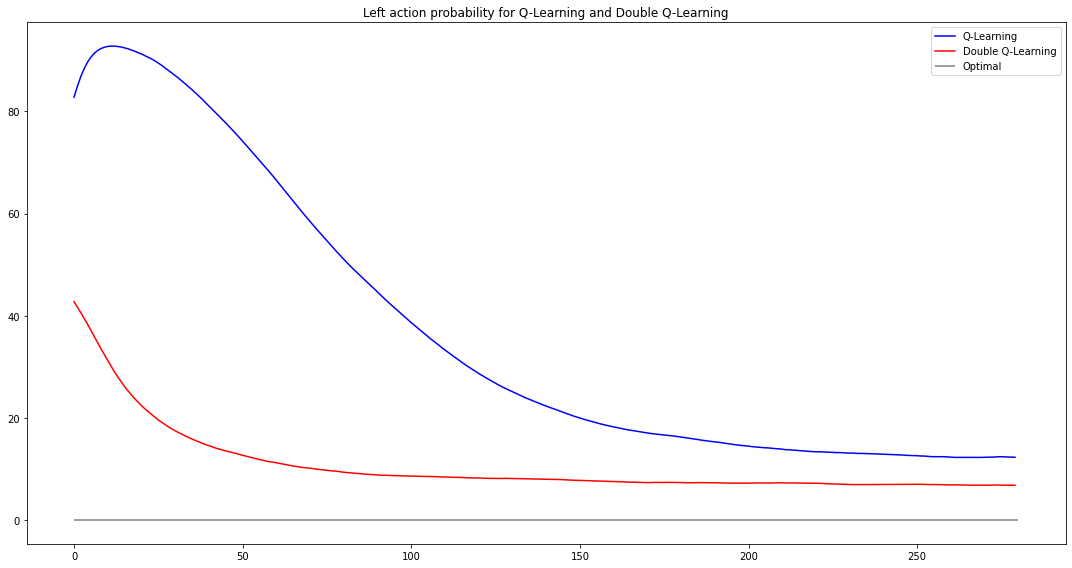

In [24]:
smoothing_radius = 20
plt.figure(figsize=(15,8))
plt.plot(
    smoothing_window(
        mean_left_action_prob_q_learning*100,
        radius=smoothing_radius
    ),
    label='Q-Learning',
    color="blue",
)
plt.plot(
    smoothing_window(
        mean_left_action_prob_double_q_learning*100,
        radius=smoothing_radius
    ),
    label='Double Q-Learning',
    color="red",
)
plt.hlines(xmin=0, xmax=num_episodes-smoothing_radius, y=epsilon/2, label='Optimal', color="gray")
plt.title('Left action probability for Q-Learning and Double Q-Learning')
plt.legend()
plt.tight_layout()
plt.savefig("../figs/ql_vs_dql_toy_example.pdf")
plt.show()